#!g1.1

Загрузим датасет 20NewsGroups

In [13]:
#!g1.1
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


In [2]:
#!g1.1
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

#загрузим обучающую выборку

newsgroups_train = fetch_20newsgroups(subset='train')

In [3]:
#!g1.1

X = newsgroups_train.data
y = newsgroups_train.target

X = pd.DataFrame(X)
X.columns = ['text']

In [ ]:
#!g1.1

X.head()

In [28]:
#!g1.1
y

array([7, 4, 4, ..., 3, 1, 8])

In [5]:
#!g1.1
X.shape, y.shape

((11314, 1), (11314,))

#!g1.1
всего 11к записей

In [6]:
#!g1.1

#пример текста 

print(X.text[300])

From: jae2001@andy.bgsu.edu (Jason Ehas)
Subject: Re: Giveaways
Organization: Home of 1984 NCAA hockey champs
Lines: 43

In article <1qi44l$kqr@access.digex.net>, steveg@cadkey.com (Steve
Gallichio) wrote:
> 
> 
> John P. Curcio (jpc@philabs.philips.com) responded to my drivel:
> 
> >steveg@cadkey.com (Steve Gallichio) writes:
> > 
> >>I still am surprised that no one has tried giving away the goodies at the end
> >>of the game. The two problems with that, of course, are that you would want
> >>to make sure the first people in the building would be assured of getting
> >>them (probably redeemable vouchers), and that the building managers want to
> >>avoid at all costs delaying people as they leave the building, if, for
> >>instance, the goodies are given to people as they exit.
> >
> >I went to the New Jersey Devils/Carvel Ice Cream Puck Night (tm) last year to
> >see the beloved Bruins play.  The pucks were given out at the end of the game.
> >I could just imagine what would have happ

In [7]:
#!g1.1

#соответствующая категория:
newsgroups_train.target_names[y[300]]

'rec.sport.hockey'

In [8]:
#!g1.1
from sklearn.model_selection import train_test_split


In [9]:
#!g1.1

#разобьем на трейн/тест 

X_train, X_test, y_train, y_test = train_test_split(X, y,  stratify = y, test_size=0.33, random_state=42)

In [48]:
#!g1.1
# Get the lists of sentences and their labels.
sentences = X_train.text.values
labels = y_train

#valid_df

берем модель дистилированного Берта

In [11]:
#!g1.1
from transformers import BertTokenizer

# попробуем облегченную модель 
# Load the BERT tokenizer. distilbert-base-uncased
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)  #стандартная модель - bert-base-uncased, 

Loading BERT tokenizer...


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


#!g1.1
## Оценим распределение длины текстов

In [39]:
#!g1.1
%%time

max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  52947
CPU times: user 1min 3s, sys: 92 ms, total: 1min 3s
Wall time: 1min 3s


In [ ]:
#!g1.1
 мы видим - что макс длина последоательности 52к 

In [40]:
#!g1.1
# тем не менее, важно понимать распределение кол-ва токенов в последовательности:

# statistics of text length (in words)
X_train['text'].apply(lambda s: len(s.split())).describe()


count     7580.000000
mean       287.968734
std        529.736149
min         17.000000
25%        108.000000
50%        177.000000
75%        294.000000
max      11278.000000
Name: text, dtype: float64

/home/jupyter/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='text'>

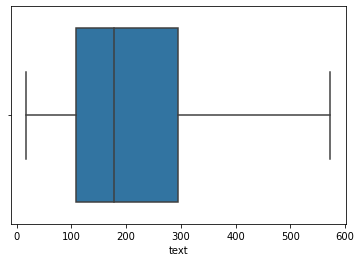

In [42]:
#!g1.1
# тем не менее, важно понимать распределение кол-ва токенов в последовательности:
import seaborn as sns
# statistics of text length (in words)
sns.boxplot(X_train['text'].apply(lambda s: len(s.split())), showfliers=False)


In [44]:
#!g1.1
print(X_train['text'].apply(lambda s: len(s.split())).quantile(0.95))
print(X_train['text'].apply(lambda s: len(s.split())).quantile(0.99))


769.0
2004.42


In [47]:
#!g1.1
print(X_train['text'].apply(lambda s: len(s.split())).quantile(0.90))


512.0


In [ ]:
#!g1.1
` мы видим, что 90% данных укладываются в стандартную длину последовательности для Берта

#!g1.1
## Токенизируем 

In [ ]:
#!g1.1
выбрали длину последовательности - равной 512

In [49]:
#!g1.1

#!g1.1
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.   Установили на основе анализа длины текстов
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
#print('Original: ', sentences[0])
#print('Token IDs:', input_ids[0])

#!g1.1

## Training & Validation Split¶

In [50]:
#!g1.1
#!g1.1
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.66 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

5,002 training samples
2,578 validation samples


In [51]:
#!g1.1
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 64  # посмотрим, как зайдет по памяти 64   ВАЖНО!  - нужно задавать гиперпараметры - как аргументы

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [52]:
#!g1.1
!nvidia-smi

Mon Dec 27 08:47:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:8C:00.0 Off |                    0 |
| N/A   34C    P0    35W / 300W |  29803MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#!g1.1
Загрузим модель и укажем кол-во классов


In [33]:
#!g1.1
num_classes = pd.Series(y).nunique()

In [34]:
#!g1.1
num_classes

20

In [53]:
#!g1.1
from transformers import BertForSequenceClassification, AdamW, BertConfig

#НУЖНО УКАЗАТЬ КОЛ-ВО КЛАССОВ
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab. используем дистилированный берт
    num_labels = num_classes, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.3.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.2.attention.k_lin.weight', 'distilbert.embeddings.word_embeddings.weight', 'distilbert.transformer.layer.2.attention.q_lin.weight', 'distilbert.transformer.layer.4.attention.q_lin.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.1.attention.out_lin.bias', 'distilbert.transformer.layer.4.ffn.lin1.bias', 'distilbert.transformer.layer.1.attention.v_lin.bias', 'distilbert.transformer.layer.3.attention.q_lin.bias', 'distilbert.transformer.layer.4.output_layer_norm.weight', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'd

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#!g1.1

# объявим вспомогателные функции

In [54]:
#!g1.1

#!g1.1
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4    # Кол-во эпох!

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#!g1.1
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


## Запускаем обучение

In [55]:
#!g1.1

#!g1.1
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     79.    Elapsed: 0:00:34.

  Average training loss: 3.02
  Training epcoh took: 0:01:07

Running Validation...
  Accuracy: 0.05
  Validation Loss: 3.01
  Validation took: 0:00:11

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     79.    Elapsed: 0:00:34.

  Average training loss: 3.00
  Training epcoh took: 0:01:07

Running Validation...
  Accuracy: 0.08
  Validation Loss: 2.97
  Validation took: 0:00:12

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     79.    Elapsed: 0:00:34.

  Average training loss: 2.92
  Training epcoh took: 0:01:07

Running Validation...
  Accuracy: 0.10
  Validation Loss: 2.88
  Validation took: 0:00:12

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     79.    Elapsed: 0:00:35.

  Average training loss: 2.85
  Training epcoh took: 0:01:08

Running Validation...
  Accuracy: 0.13
  Validation Loss: 2.82
  Validation took: 0:00:12

Training complete!
Total tr

In [ ]:
#!g1.1
model

In [38]:
#!g1.1
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,3.02,3.00,0.05,0:02:39,0:00:31
2,2.99,2.95,0.06,0:02:29,0:00:26
3,2.83,2.68,0.13,0:02:30,0:00:26
4,2.61,2.56,0.15,0:02:30,0:00:26


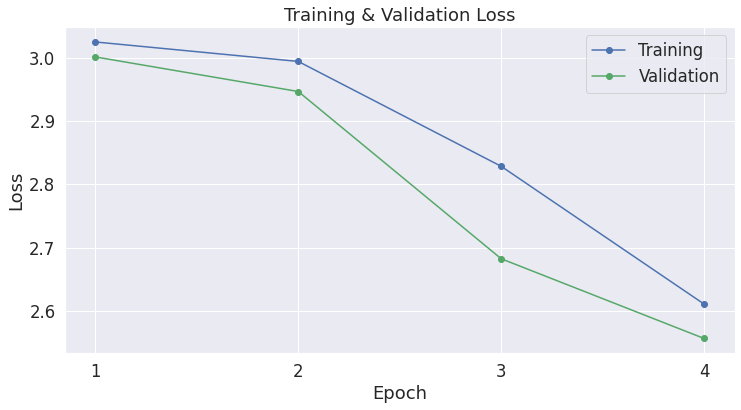

In [39]:
#!g1.1

#!g1.1
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
#!g1.1
как будто можно еще обучить на несколько эпохах

In [ ]:
#!g1.1
X_test

In [41]:
#!g1.1

#!g1.1
import pandas as pd

# Load the dataset into a pandas dataframe.

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(X_test.shape[0]))

# Create sentence and label lists
sentences = X_test.text.values
labels = y_test

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.  # max lenght IS SET TO 64!
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32    #BATCH SIZE!

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 3,734



/home/jupyter/.local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#!g1.1


In [43]:
#!g1.1
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,734 test sentences...
    DONE.


In [44]:
#!g1.1
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)




In [45]:
#!g1.1
flat_true_labels.shape, flat_predictions.shape

((3734,), (3734,))

In [46]:
#!g1.1
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

In [47]:
#!g1.1
print('accuracy', np.round(accuracy_score(flat_true_labels, flat_predictions),3)) #качество на тесте
print('f1', np.round(f1_score(flat_true_labels, flat_predictions, average='macro'),2)) #качество на тесте


accuracy 0.121
f1 0.08


In [ ]:
#!g1.1
